## mobileNetv2

## Introduction
After the outbreak of covid pandemic, masks became one of the essential items for protecting the health of individuals against respiratory disease. This Computer Vision project is mainly to develop models to detect whether people within the camera field are wearing masks, not wearing masks, or wearing them improperly.

In [3]:
#import the libraries
import numpy as np
import pandas as pd 
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import cv2
import random as rand
import xmltodict
import glob
from datetime import datetime
import xml.etree.ElementTree as ET 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import matplotlib.patches as mpatches

## Dataset exploration
https://www.kaggle.com/datasets/andrewmvd/face-mask-detection

Mainly, there are two set, annotation and image which is xml and jpg format separately. Our 4 models share the same dataset, xml file contain the label of image like what is the label and where is the human face aligned this label.

In [4]:
cwd = os.getcwd()
annotations_path = cwd+"/dataset/annotations/"
images_path = cwd+"/dataset/images/" 

In [5]:
img_set=[] ##used to save all the image 
xml_set=[] ##save annotation of image

for root, dirs, files in os.walk(cwd + '/dataset/'):
    for file in files:    
        if file == '.DS_Store': #avoid DS in the dict
            continue
        if os.path.join(root, file)[-3:]!="xml":
            img_set.append(file)
        else:
            xml_set.append(file)
             #Generate Label

In [6]:
img_set[1][:-4]

'maksssksksss716'

Total number of image

In [7]:
len(xml_set) 

853

### List all the label of image,
To be noticed, there might be more than one label in an image, so there is 3232 in with mask labels, 123 in wear incorrectly and 717 in withous mask

In [8]:
img_category=[] ##store all the label
for img in img_set:
    if '.DS_Store' in img:
        continue
    with open(annotations_path+img[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            img_category.append(temp[i]["name"])
    else:
        img_category.append(temp["name"])
        

Items = Counter(img_category).keys() #key
values = Counter(img_category).values() #value
print(Items,'\n',values)

dict_keys(['with_mask', 'mask_weared_incorrect', 'without_mask']) 
 dict_values([3232, 123, 717])


### Data visualisation
Here we can there is a high volumn of with mask and very low in mask wear incorrectly which might cause the strong bias, but hopefully, at least there are 123 labls wear incorrectly.

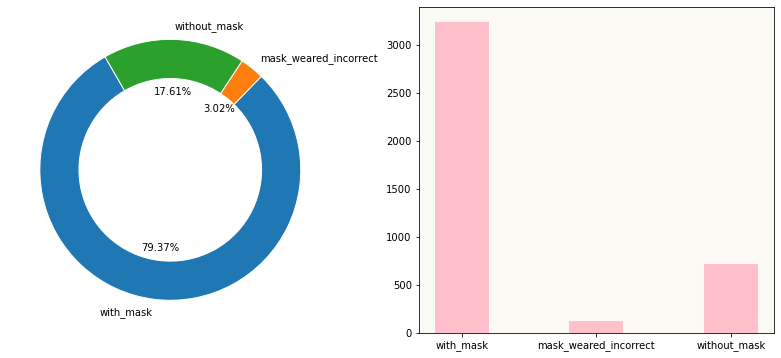

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie(values,wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=Items, radius=1, startangle = 120, autopct='%1.2f%%')

ax2 = plt.bar(Items, list(values),
              color ='pink',width = 0.4)

plt.show()

### Visualisation of three classes like with mask on human face
This step is use the xml label to show its true label

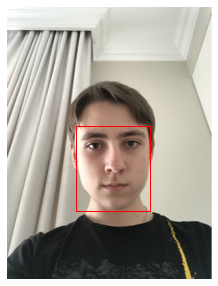

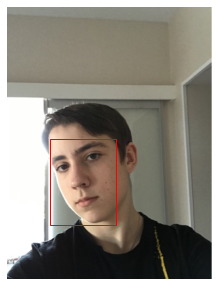

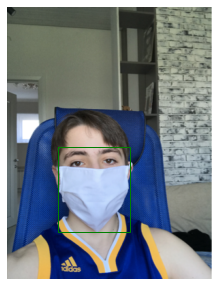

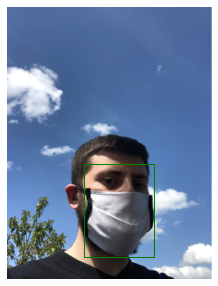

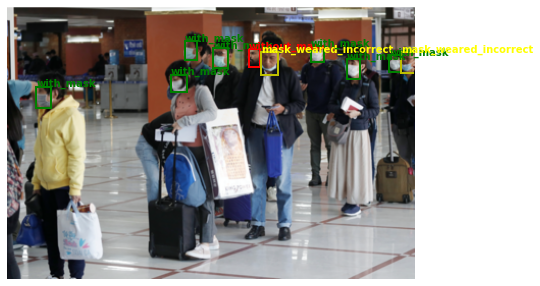

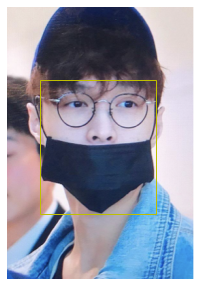

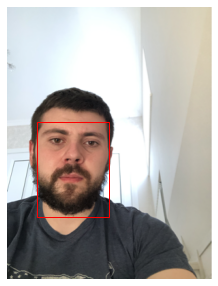

In [312]:
def face_cas(img): 
    with open(annotations_path+img[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    image=plt.imread(os.path.join(images_path+img))
    fig,ax=plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(10,5)
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            ###with_mask
            if temp[i]["name"]=="with_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='g',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("with_mask", (rx, ry), color='green', weight='bold', fontsize=10, ha='left', va='baseline')
            ###without_mask
            if temp[i]["name"]=="without_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))     
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='r',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("without_mask", (rx, ry), color='red', weight='bold', fontsize=10, ha='left', va='baseline')
            ###mask_weared_incorrect
            if temp[i]["name"]=="mask_weared_incorrect":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='y',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("mask_weared_incorrect", (rx, ry), color='yellow', weight='bold', fontsize=10, ha='left', va='baseline')
    else:
        x,y,w,h=list(map(int,temp["bndbox"].values()))
        edgecolor={"with_mask":"g","without_mask":"r","mask_weared_incorrect":"y"}
        mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor=edgecolor[temp["name"]],facecolor="none",)
    ax.imshow(image)
    ax.add_patch(mpatch)

fun_images = img_set.copy()
for i in range(1,8):
    face_cas(fun_images[i])

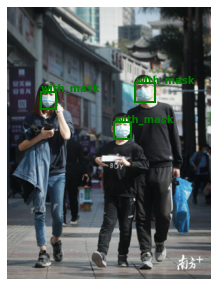

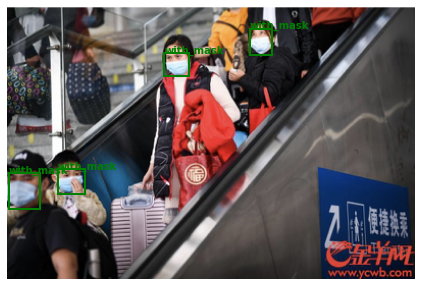

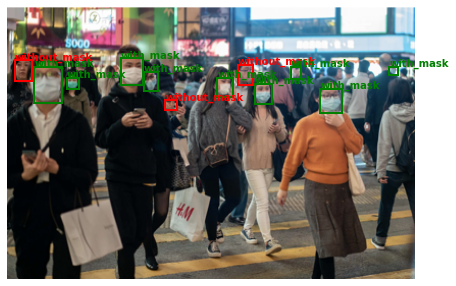

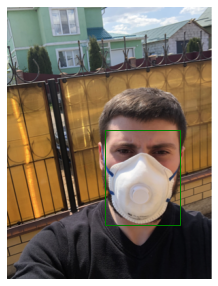

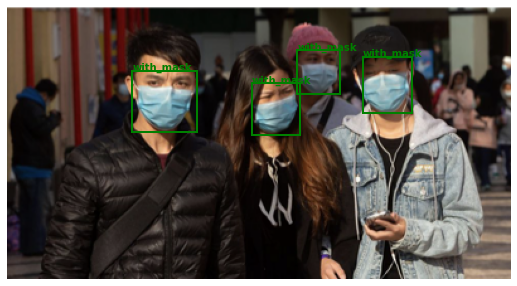

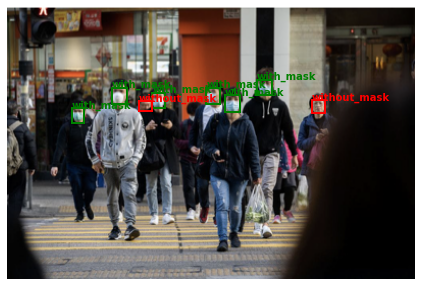

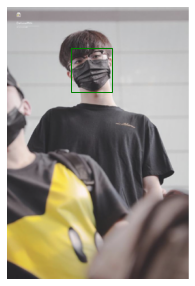

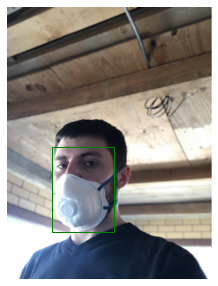

In [272]:
for i in range(8,16):
    face_cas(fun_images[i])

## Data preprocessing 
convert image into np array and convert its corresponding label (categorical attribute) to numeric attribute 

Without mask: 0, With mask: 1, Wear incorrectly: 2

In [10]:
#This function will get the coordinates of face given in the annotations file
# the coordinates of lower left corner and upper right corner
def generate_box(obj):  
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]
#This function will give label assciated with each label and convert them to numbers
def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    else:
        return 0
#Using in this main function we parse the annotations file and get the objects out from them
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
            
        boxes=np.array(boxes)
        labels=np.array(labels)

        img_id = np.array(image_id)
# Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return (target,num_objs)

In [11]:
# Here we use the above functions and save results in lists
targets=[]#store coordinates
numobjs=[]#stores number of faces in each image

for i in range(853):
    file_image = 'maksssksksss'+ str(i) + '.png'
    file_label = 'maksssksksss'+ str(i) + '.xml'
    img_path = os.path.join(images_path, file_image)
    label_path = os.path.join(annotations_path, file_label)
    #Generate Label
    target,numobj = generate_target(i, label_path)
    targets.append(target)
    numobjs.append(numobj)

In [12]:
face_images=[]  #store the image containg face
face_labels=[] #store the number of label of face on each image
for i in range(853):
    img_path = r"/Users/laurencejin/COMP9444_proj/dataset/images/maksssksksss{}.png".format(i)
    img = cv2.imread(img_path)
    for j in range(numobjs[i]):
#       Get coordinates of ith image in list 
        locs=(targets[i]['boxes'][j])
#       Get the face from the image using the coordinates
        img1=img[locs[1]:locs[3],locs[0]:locs[2]]
        img1 = cv2.resize(img1, (224, 224))
        img1 = img_to_array(img1)
        img1 = preprocess_input(img1)
        face_images.append(img1)
        face_labels.append(targets[i]['labels'][j])

face_images= np.array(face_images, dtype="float32")
face_labels = np.array(face_labels)

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


In [13]:
len(face_labels) ##total number of human face

4072

In [14]:
unique, counts = np.unique(face_labels, return_counts=True)
dict(zip(unique, counts)) ##each label with the number of human face 

{0: 717, 1: 3232, 2: 123}

In [15]:
#Encode the labels in one hot encode form
lb = LabelEncoder()
labels = lb.fit_transform(face_labels)
labels = to_categorical(labels)
labels

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

## Apply the model to train the dataset

In [16]:
#Perform data augmentation.
aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

In [17]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_shape=(224, 224, 3))

# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

2022-07-31 20:17:09.403316: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Split the training and testing set

In [19]:
#divide data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(face_images, labels,
    test_size=0.2, stratify=labels, random_state=42)

## Raw Training the model

In [18]:
#define the hyperparamets for traing te neural network
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [21]:
#Complie the model and train it
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the head of the network
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/20
101/101 [==============================] - 142s 1s/step - loss: 0.5450 - accuracy: 0.7950 - val_loss: 0.3716 - val_accuracy: 0.8687
Epoch 2/20
101/101 [==============================] - 130s 1s/step - loss: 0.3576 - accuracy: 0.8716 - val_loss: 0.3276 - val_accuracy: 0.8969
Epoch 3/20
101/101 [==============================] - 132s 1s/step - loss: 0.3145 - accuracy: 0.8912 - val_loss: 0.3133 - val_accuracy: 0.8933
Epoch 4/20
101/101 [==============================] - 130s 1s/step - loss: 0.2904 - accuracy: 0.8983 - val_loss: 0.2801 - val_accuracy: 0.9043
Epoch 5/20
101/101 [==============================] - 128s 1s/step - loss: 0.2685 - accuracy: 0.9079 - val_loss: 0.2714 - val_accuracy: 0.9104
Epoch 6/20
101/101 [==============================] - 129s 1s/step - loss: 0.2568 - accuracy: 0.9085 - val_loss: 0.2506 - val_accuracy: 0.9190
Epoch 7/20
101/101 [==============================] - 129s 1s/step - loss: 0.2427 - accuracy: 0.9091 - val_loss: 0.2552 - val_accuracy: 0.9153

[INFO] evaluating network...
26/26 [==============================] - 38s 1s/step
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       143
           1       0.96      0.97      0.96       647
           2       0.77      0.40      0.53        25

    accuracy                           0.93       815
   macro avg       0.86      0.75      0.78       815
weighted avg       0.93      0.93      0.93       815



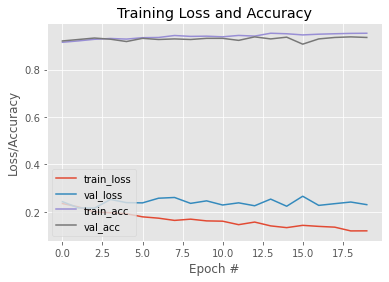

In [73]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [36]:
x_pred=model.predict(testX, batch_size=32)

26/26 [==============================] - 28s 1s/step


Mean Average Precision is 0.79 in the first round

In [63]:
from sklearn.metrics import average_precision_score
meanAp = average_precision_score(y_score=x_pred, y_true=testY)
meanAp

0.7906016805535918

## Fine-tunning and re-train the model
I change BS from 32 to 1

In [71]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 1

In [72]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the head of the network
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/20
3257/3257 [==============================] - 272s 81ms/step - loss: 0.2355 - accuracy: 0.9146 - val_loss: 0.2434 - val_accuracy: 0.9202
Epoch 2/20
3257/3257 [==============================] - 273s 84ms/step - loss: 0.2213 - accuracy: 0.9205 - val_loss: 0.2171 - val_accuracy: 0.9264
Epoch 3/20
3257/3257 [==============================] - 231s 71ms/step - loss: 0.2001 - accuracy: 0.9272 - val_loss: 0.2160 - val_accuracy: 0.9325
Epoch 4/20
3257/3257 [==============================] - 254s 78ms/step - loss: 0.1967 - accuracy: 0.9306 - val_loss: 0.2527 - val_accuracy: 0.9276
Epoch 5/20
3257/3257 [==============================] - 241s 74ms/step - loss: 0.1924 - accuracy: 0.9282 - val_loss: 0.2392 - val_accuracy: 0.9178
Epoch 6/20
3257/3257 [==============================] - 255s 78ms/step - loss: 0.1795 - accuracy: 0.9340 - val_loss: 0.2383 - val_accuracy: 0.9313
Epoch 7/20
3257/3257 [==============================] - 250s 77ms/step - loss: 0.1738 - accuracy: 0.9349 - val_loss: 0

## Result : Display with evaluated metric, like accuracy, f1 score and precision etc.

[INFO] evaluating network...
26/26 [==============================] - 29s 997ms/step
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       143
           1       0.95      0.97      0.96       647
           2       0.75      0.24      0.36        25

    accuracy                           0.93       815
   macro avg       0.85      0.69      0.72       815
weighted avg       0.92      0.93      0.92       815



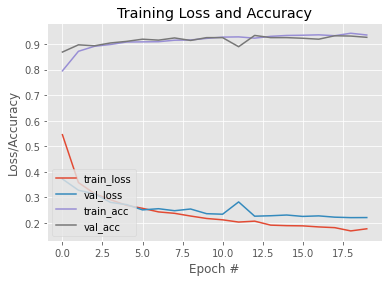

In [23]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [74]:
y_pred=model.predict(testX, batch_size=32)

26/26 [==============================] - 32s 1s/step


Mean Average Precision here

In [76]:
meanAp = average_precision_score(y_score=y_pred, y_true=testY)
meanAp

0.8127252359298582

In [80]:
for i in range(3):
    ap = average_precision_score(y_score=y_pred[:,i], y_true=testY[:,i])
    print("ap{} = {}".format(i,ap))

ap0 = 0.9295603899250248
ap1 = 0.9865030888786935
ap2 = 0.5221122289858563


# Evaluation of the result

We can see the result above, MobileNetv2 produced higher accuracy – 93% (but used to be 94%) but it doesn't matter
because our project is working towards multi-class classification, and the majority of the images from the dataset (80%) belong to people wearing masks therefore the evaluation of the final result should primarily be considered according to MAP. MAP is the area under precison/recall curve which can neglect this unbalanced dataset which is 81% as the highest value compared to other model

## Result: Prediction visualisation 

In [211]:
# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = cwd+"/helper/deploy.prototxt"
weightsPath = cwd+"/helper/res10_300x300_ssd_iter_140000.caffemodel"

print(prototxtPath)
print(weightsPath)

net = cv2.dnn.readNet(prototxtPath, weightsPath)

[INFO] loading face detector model...
/Users/laurencejin/COMP9444_proj/helper/deploy.prototxt
/Users/laurencejin/COMP9444_proj/helper/res10_300x300_ssd_iter_140000.caffemodel


In [344]:
def plot_image(imagepath):
    image = cv2.imread(imagepath)

    orig = image.copy()
    (h, w) = image.shape[:2]
    # construct a blob from the image
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
        (104.0, 177.0, 123.0))
    # pass the blob through the network and obtain the face detections
    net.setInput(blob)
    detections = net.forward()
    
    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the detection
        confidence = detections[0, 0, i, 2]
        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            # ensure the bounding boxes fall within the dimensions of the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = image[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)
            # pass the face through the model to determine if the face has a mask or not
            (withoutMask, mask, incorrect) = model.predict(face)[0]
            # determine the class label and color we'll use to draw
            # the bounding box and text
            print(mask, withoutMask, incorrect)
            if mask > withoutMask and mask > incorrect:
                label = "Mask" 
                color = (0, 255, 0) 
            if incorrect > mask and incorrect > withoutMask:
                label = "incorrectWear" 
                color = (0, 255, 255) 
            if (withoutMask > mask and withoutMask > incorrect):
                label = "withoutMask" 
                color = (0, 0, 255) 
            # include the probability in the label
            label = "{}:{:.2f}%".format(label, max(mask, withoutMask,incorrect) * 100)
            # display the label and bounding box rectangle on the output frame
            cv2.putText(image, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 10)
            # show the output image
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGBA)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(image)

In [345]:
TestImagePath = []

import os
for dirname, _, filenames in os.walk(images_path):
    for filename in filenames:
        TestImagePath.append(os.path.join(dirname, filename))

Almost correct display with red without mask, green with mask and yellow wear incorrectly, you can see there are 3 numerical number in pair print below, it represent each percentage or possibility of the class is, like the first one it has 99.37% be with mask, then it must be with mask. It will choose the highest possiblity.

1/1 [==============================] - 0s 95ms/step
0.99378234 0.0020248753 0.004192791
1/1 [==============================] - 0s 151ms/step
0.9913202 0.0004514224 0.008228371
1/1 [==============================] - 0s 71ms/step
0.03718034 0.95392907 0.00889063
1/1 [==============================] - 0s 70ms/step
0.9955455 0.0017121817 0.0027423033
1/1 [==============================] - 0s 68ms/step
0.9988519 3.8085263e-06 0.0011443022
1/1 [==============================] - 0s 80ms/step
0.998176 0.0007017618 0.0011221963
1/1 [==============================] - 0s 78ms/step
0.006059483 0.9925684 0.0013721754
1/1 [==============================] - 0s 90ms/step
0.13798153 0.8060565 0.055962
1/1 [==============================] - 0s 98ms/step
0.9994863 3.8907838e-05 0.0004746887


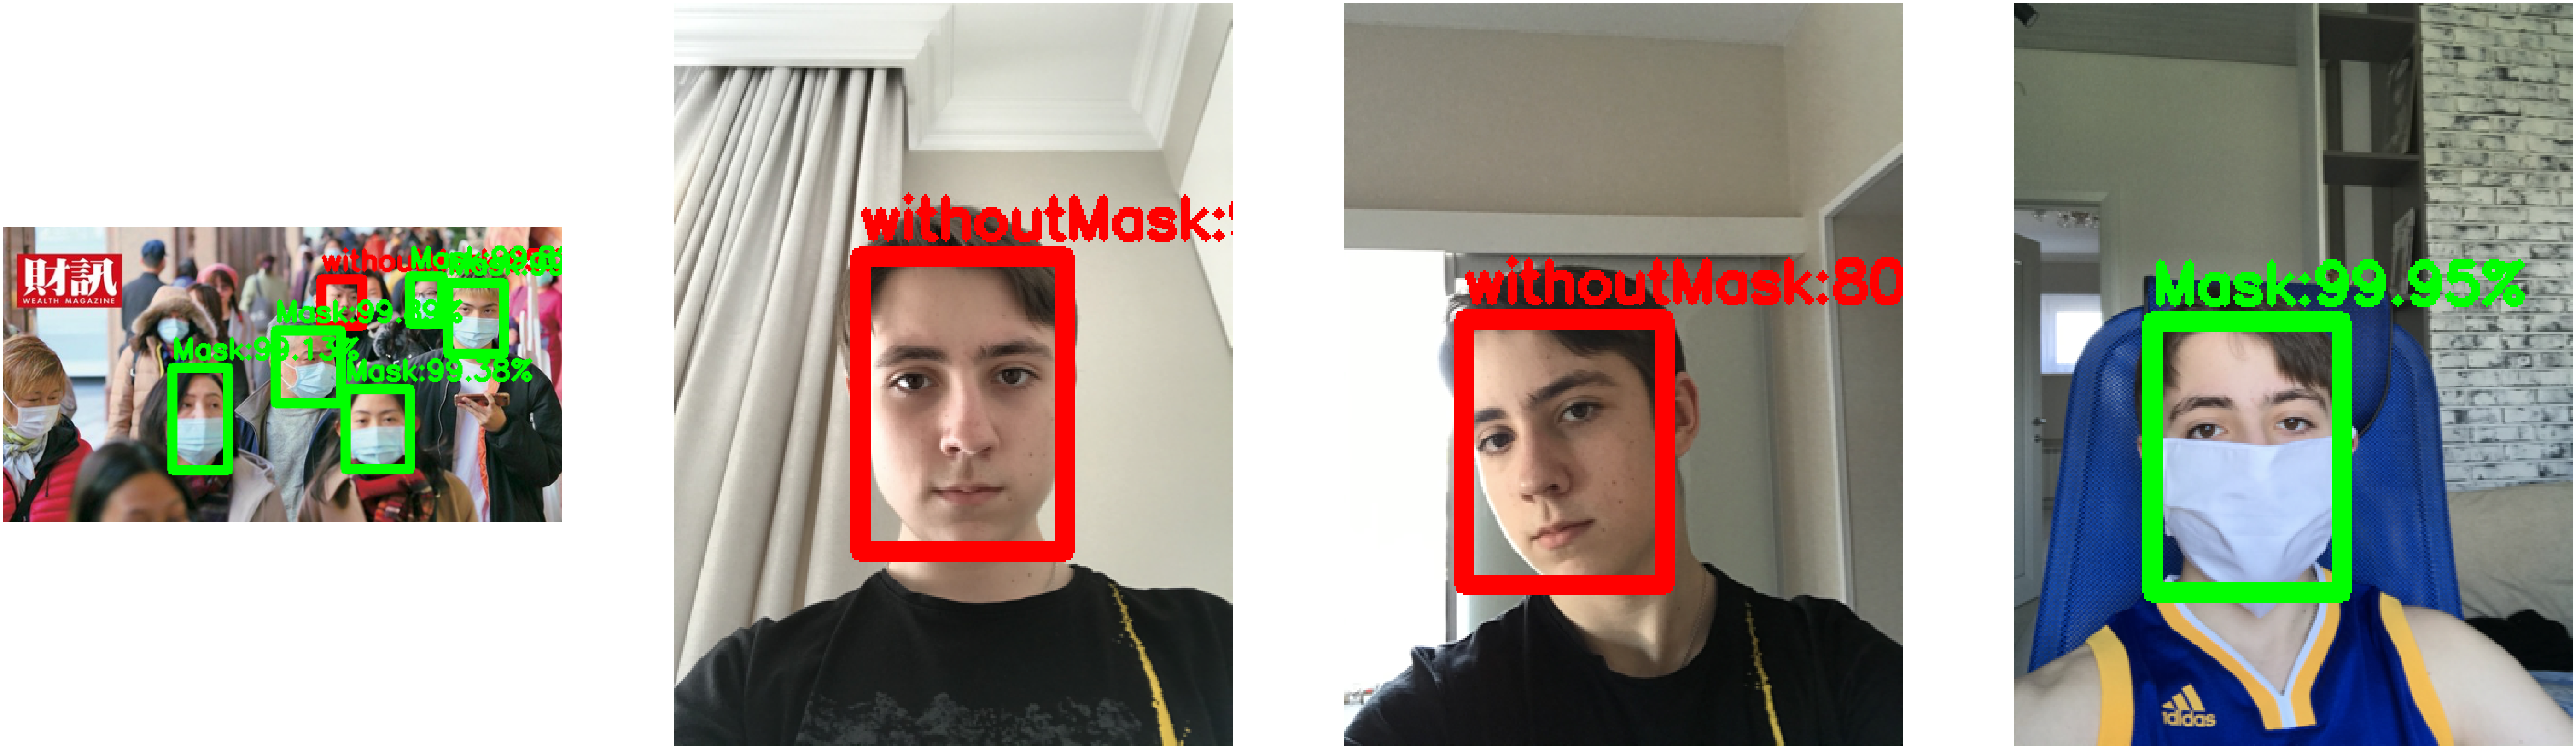

In [349]:
num_rows=2
num_cols=2
num_images=num_rows*num_cols

plt.figure(figsize=(100,100))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, i+1)
    plot_image(TestImagePath[i])
plt.show()

/Users/laurencejin/COMP9444_proj/dataset/images/maksssksksss11.png
1/1 [==============================] - 0s 134ms/step
0.32545915 0.026063804 0.6484771
1/1 [==============================] - 0s 91ms/step
0.999151 0.00012495356 0.00072410353
1/1 [==============================] - 0s 105ms/step
0.9837338 0.002187663 0.01407854
1/1 [==============================] - 0s 76ms/step
0.99082595 0.00024723855 0.008926823


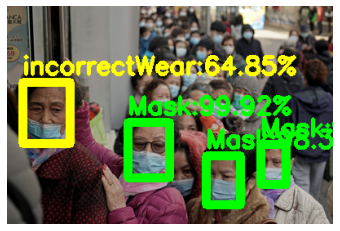

In [347]:
for im in TestImagePath:
    if 's11.' in im:
        print(im)
        plot_image(im)

# Discussion about visualisation
As demo mentioned, some face are not detected, it might be caused by caffeemodel, because mobileNetV2 is a slight-structure training model it doesn't have the function to capture the face, so it need the dimension which is actual location of face. Then caffeemodel do that to detect the human face, then it pass the 'face' pixel to mobilenetv2 to make prediction, that cause the bias with some people don't have a detection. But mostly, it is fine

# Disccusion the model

MobileNetv2 takes the least amount of time, which is probably due to its light-weighted. These reasons make us choose transfer learning with MobileNetV2 model as our final solution. MobileNetv2 model is good enough to be deployed in real-world application, with lightweight features, its fast and high accuracy detection.

Desptie it has a remakable performance, it still has demerit like you can see it can't visualise the face directly so the tool to capture the face and preprocessing to capture the face make important and harder. Overall, it is still the best model we explore in this assignment.

## Reference
### https://www.kaggle.com/code/notadithyabhat/face-mask-detector/notebook